# Project: Investigating NYC Citibike Dataset (2016-2017)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>


## Introduction

### Dataset Description 

This dataset collects information
from Citibike useage across NYC. The data
includes individual rides by users as well
as station useage where citibikes are set up.

Alta Bicycle Share, the company that owns and operates the Citi Bike program, is facing some unexpected financial difficulties as a result of dropping sponsorship revenue for the bike share program. Faced with a revenue shortfall, Alta would like you to mine the Citi Bike stations and trips data to come up with solutions and projected revenue impact. Alternatively, you could investigate ways to reduce expenses without impacting ride volume too negatively.

- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (unknown, male, female)


### Exploration for Analysis
- Trip Length
- What day of the week, time, and months have the most users of the bikes
- Age
- Stations Analysis

<a id='wrangling'></a>
## Data Wrangling

> In this section of the report, I will load in the data, check for cleanliness, and trim and clean

In [4]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#import google cloud package to retrieve bigquery public data
import google.cloud
from google.cloud import bigquery

In [6]:
#Setting an environment variable for GOOGLE_APPLICATION_CREDENTIALS
import os
credential_path = "/Users/hatif/downloads/helpful-scion-339004-74102e1e0570.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

In [7]:
#initialize a client
client = bigquery.Client()

In [8]:
#import the data using a sql query and convert it to a dataframe
bigquery_client = bigquery.Client()
QUERY = """
select *
from `bigquery-public-data.new_york_citibike.citibike_trips`
where (EXTRACT(YEAR FROM starttime)>= 2016 and EXTRACT(YEAR FROM starttime)<= 2017) and
(EXTRACT(YEAR FROM stoptime) >= 2016 and EXTRACT(YEAR FROM stoptime) <= 2017)
"""
Query_Results = bigquery_client.query(QUERY)
df = Query_Results.to_dataframe()

In [9]:
df.describe().round(2)
#the max longitude is for the start station is 0 which makes no sense since 0 is in europe we will need to drop values
#tripduration max value is 9million seconds which is also a huge outlier. we will need to drop values
#the birth year min is also 1874 which can't be true since they're likely not alive
#we need to convert timestampt to datetime

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year
count,24381275.00,24381275.00,24381275.00,24381275.00,24381275.00,24381275.00,24381275.00,24381275.0,21578847.00
mean,1007.36,1218.87,40.74,-73.99,1209.24,40.74,-73.99,22600.6,1978.51
std,13618.35,1282.02,0.06,0.10,1278.00,0.09,0.15,4998.0,11.75
min,61.00,72.00,0.00,-74.03,72.00,0.00,-74.09,14529.0,1874.00
25%,382.00,349.00,40.72,-74.00,348.00,40.72,-74.00,18194.0,1970.00
50%,639.00,476.00,40.74,-73.99,474.00,40.74,-73.99,22234.0,1981.00
75%,1101.00,3088.00,40.76,-73.98,3084.00,40.76,-73.98,26729.0,1988.00
max,9735948.00,3654.00,45.51,0.00,3654.00,45.51,0.00,33481.0,2001.00


In [10]:
#lets test to see if there were a handful of 0 values
df = df.loc[df['start_station_longitude'] <-1]
df.describe().round(2)

#there were since max is now -73.57

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year
count,24381234.00,24381234.00,24381234.00,24381234.00,24381234.00,24381234.00,24381234.00,24381234.00,21578811.00
mean,1007.35,1218.87,40.74,-73.99,1209.23,40.74,-73.99,22600.59,1978.51
std,13618.35,1282.01,0.03,0.02,1278.00,0.09,0.15,4998.00,11.75
min,61.00,72.00,40.45,-74.03,72.00,0.00,-74.09,14529.00,1874.00
25%,382.00,349.00,40.72,-74.00,348.00,40.72,-74.00,18194.00,1970.00
50%,639.00,476.00,40.74,-73.99,474.00,40.74,-73.99,22234.00,1981.00
75%,1101.00,3088.00,40.76,-73.98,3084.00,40.76,-73.98,26729.00,1988.00
max,9735948.00,3654.00,45.51,-73.57,3654.00,45.51,0.00,33481.00,2001.00


In [11]:
#the average trip duration is about 1007 seconds on an excessive side an hour would be a long ride. we will remoe
#all trip duration values more than an hour so more than 3600 seconds.
df = df.loc[df['tripduration'] <3600]
df.describe().round(2)

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year
count,24128090.00,24128090.00,24128090.00,24128090.00,24128090.00,24128090.00,24128090.00,24128090.00,21485045.00
mean,802.81,1215.68,40.74,-73.99,1205.11,40.74,-73.99,22611.86,1978.51
std,573.46,1280.74,0.03,0.02,1276.34,0.06,0.09,4998.61,11.75
min,61.00,72.00,40.45,-74.03,72.00,0.00,-74.07,14529.00,1874.00
25%,380.00,349.00,40.72,-74.00,348.00,40.72,-74.00,18202.00,1970.00
50%,632.00,476.00,40.74,-73.99,474.00,40.74,-73.99,22269.00,1981.00
75%,1080.00,3087.00,40.76,-73.98,3082.00,40.76,-73.98,26737.00,1988.00
max,3599.00,3654.00,45.51,-73.57,3654.00,45.51,0.00,33481.00,2001.00


In [12]:
#convert timestamp to a datetime value
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

In [13]:
#drop any birth values that are less than 1950 since most 70 years wouldn't be able to ride a bike
df = df.loc[df['birth_year'] >=1950]
df.describe().round(2)

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year
count,21232356.00,21232356.00,21232356.00,21232356.00,21232356.00,21232356.00,21232356.00,21232356.00,21232356.00
mean,746.50,1195.06,40.74,-73.99,1183.90,40.74,-73.99,22730.47,1978.93
std,534.67,1272.69,0.03,0.02,1267.88,0.06,0.09,5009.16,11.13
min,61.00,72.00,40.45,-74.03,72.00,0.00,-74.07,14529.00,1950.00
25%,362.00,349.00,40.72,-74.00,347.00,40.72,-74.00,18297.00,1971.00
50%,588.00,474.00,40.74,-73.99,472.00,40.74,-73.99,22586.00,1981.00
75%,978.00,3078.00,40.75,-73.98,3070.00,40.75,-73.98,26841.00,1988.00
max,3599.00,3654.00,45.51,-73.57,3654.00,45.51,0.00,33481.00,2001.00


<a id='eda'></a>
## Exploratory Data Analysis

> Moving on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions.

### Trip length

In [14]:
#we have to create a new column that measures duration in minutes
df['tripdurationminutes'] = (df['tripduration']/60).round(2)
df.head(5)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,tripdurationminutes
0,253,2016-06-07 15:21:24,2016-06-07 15:25:37,475,E 16 St & Irving Pl,40.735243,-73.987586,345,W 13 St & 6 Ave,40.736494,-73.997044,20614,Subscriber,1971.0,male,,4.22
1,1513,2017-11-01 15:36:07,2017-11-01 16:01:21,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,3151,E 81 St & York Ave,40.772838,-73.949892,27066,Subscriber,1971.0,male,,25.22
2,1647,2016-09-22 08:26:11,2016-09-22 08:53:39,3070,McKibbin St & Manhattan Ave,40.705109,-73.944073,350,Clinton St & Grand St,40.715595,-73.987030,22553,Subscriber,1971.0,female,,27.45
3,420,2016-05-06 17:01:19,2016-05-06 17:08:19,238,Bank St & Washington St,40.736197,-74.008592,238,Bank St & Washington St,40.736197,-74.008592,22461,Subscriber,1971.0,male,,7.00
4,1253,2016-05-11 18:44:36,2016-05-11 19:05:30,501,FDR Drive & E 35 St,40.744219,-73.971212,336,Sullivan St & Washington Sq,40.730477,-73.999061,18872,Subscriber,1971.0,female,,20.88


In [58]:
df['tripdurationminutes'].mean()

12.441732343315993

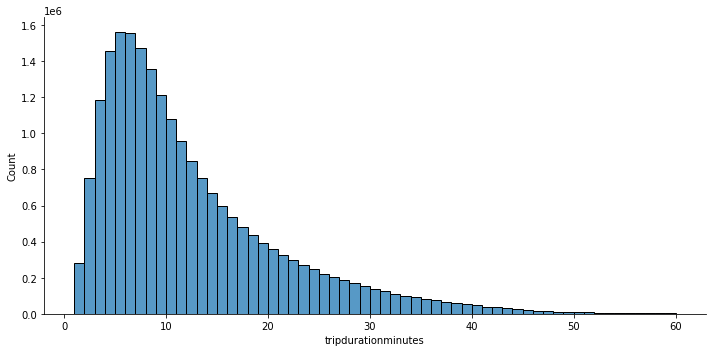

In [16]:
#plot disribution of trip lengths
sns.displot(data=df,kind="hist", x="tripdurationminutes", bins=range(1,61), aspect=8/4)

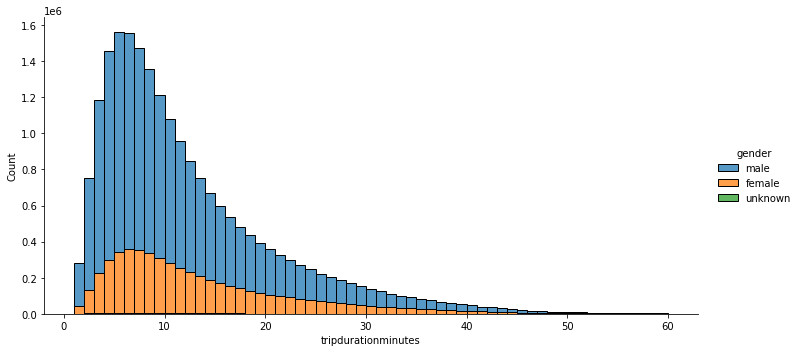

In [19]:
#plot the distribution of ttrip lengths by usertype
sns.displot(data=df,kind="hist", x="tripdurationminutes", hue='gender', multiple='stack',bins=range(1,61), aspect=8/4)

### primary riding group are men

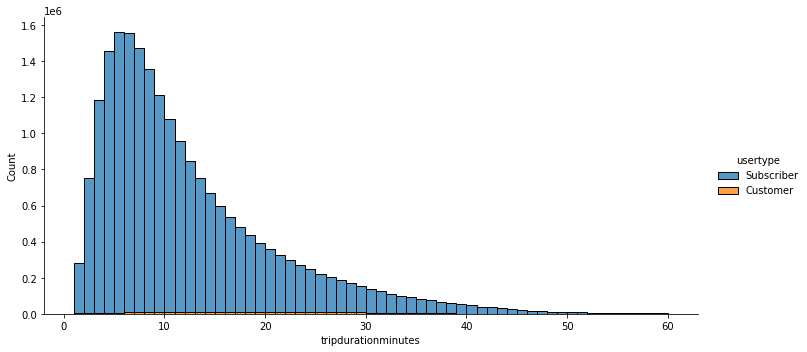

In [20]:
sns.displot(data=df,kind="hist", x="tripdurationminutes", hue='usertype', multiple='stack',bins=range(1,61), aspect=8/4)
### primary riders are Subscribers who pay a yearly fee

### What day of the week, time, and months have the most users of the bikes?

In [12]:
#first we create a column value for the start hour, day, and month
df['starthour']=df['starttime'].dt.hour.astype('category')
df['startday']=df['starttime'].dt.day.astype('category')
df['startmonth']=df['starttime'].dt.month.astype('category')

Text(0.5, 1.0, 'Number of Riders by the Hour')

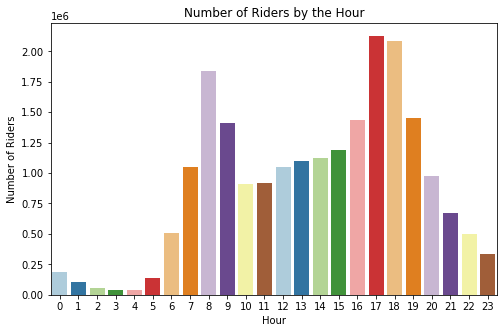

In [13]:
#visualizing the number of riders per hour
fig, ax = plt.subplots(figsize=(8, 5))  
h = sns.countplot(data=df, x="starthour", palette ="Paired")
ax.set(xlabel="Hour", ylabel = "Number of Riders")
plt.title("Number of Riders by the Hour")

### Looks like there is a high density of riders during early morning between 6 and 9, and the afternoon
### and late evening from 3 to 7

Text(0.5, 1.0, 'Number of Riders by the Day')

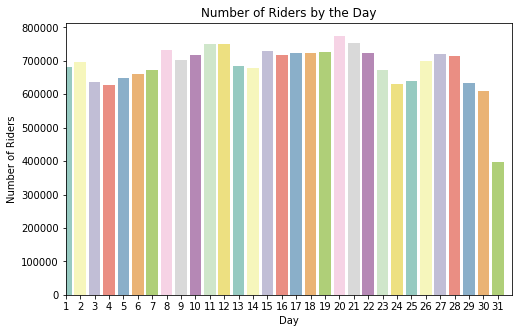

In [14]:
#visualizing the number of riders per day of a month
fig, ax = plt.subplots(figsize=(8, 5))
h = sns.countplot(data=df, x = 'startday', palette="Set3")
h.set(xlim = (0,31))
ax.set(xlabel="Day", ylabel = "Number of Riders")
plt.title("Number of Riders by the Day")

### There is pretty consistent distribution of riders per day however, we should break this down into weekday vs weekend

In [15]:
##visualizing the number of riders per day seperated by the weekend
#create
df['weekday']=df['starttime'].dt.weekday.astype('category')
df['dayofweek'] = df['starttime'].dt.day_name()
df['weekend'] = df['starttime'].dt.dayofweek >= 5
df.head(5)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,usertype,birth_year,gender,customer_plan,starthour,startday,startmonth,weekday,dayofweek,weekend
0,1126,2017-06-11 09:32:56,2017-06-11 09:51:43,476,E 31 St & 3 Ave,40.743943,-73.979661,79,Franklin St & W Broadway,40.719116,...,Subscriber,1971.0,female,,9,11,6,6,Sunday,True
1,286,2016-03-04 13:17:07,2016-03-04 13:21:53,345,W 13 St & 6 Ave,40.736494,-73.997044,405,Washington St & Gansevoort St,40.739323,...,Subscriber,1971.0,male,,13,4,3,4,Friday,False
2,883,2017-05-17 16:20:06,2017-05-17 16:34:50,3409,Bergen St & Smith St,40.686744,-73.990632,3348,Coffey St & Conover St,40.677236,...,Subscriber,1971.0,female,,16,17,5,2,Wednesday,False
3,365,2016-07-14 18:13:05,2016-07-14 18:19:10,442,W 27 St & 7 Ave,40.746647,-73.993915,284,Greenwich Ave & 8 Ave,40.739017,...,Subscriber,1971.0,male,,18,14,7,3,Thursday,False
4,781,2016-09-12 08:51:57,2016-09-12 09:04:59,3170,W 84 St & Columbus Ave,40.785000,-73.972834,137,E 56 St & Madison Ave,40.761628,...,Subscriber,1971.0,male,,8,12,9,0,Monday,False


Text(0.5, 1.0, 'Number of Riders by Weekday')

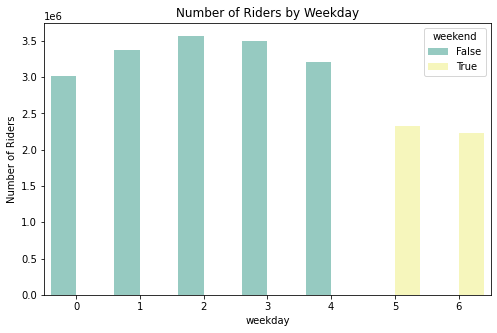

In [16]:
#visualizing the number of riders pby weekday, 0 is Monday and 5 and 6 are Saturday and Sunday 
fig, ax = plt.subplots(figsize=(8, 5))
h = sns.countplot(data=df, x = 'weekday', hue ='weekend' ,palette="Set3")
ax.set(ylabel = "Number of Riders")
#ax.set_xticklabels(df['dayofweek'])
plt.title("Number of Riders by Weekday")

#we can see that weekdays the citibike are being used frequently but there is opportunity to incentivize it being
#on the weekend

Text(0.5, 1.0, 'Number of Riders by the Month')

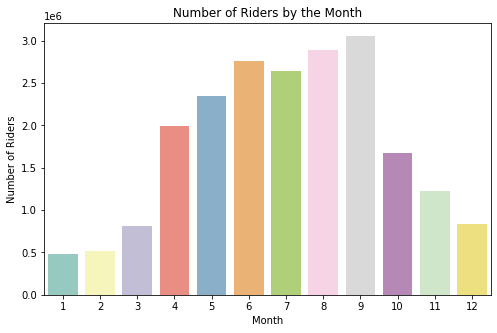

In [17]:
#visualizing the number of riders per month
fig, ax = plt.subplots(figsize=(8, 5))
h = sns.countplot(data=df, x = 'startmonth', palette="Set3")
ax.set(xlabel="Month", ylabel = "Number of Riders")
plt.title("Number of Riders by the Month")

###the spring and summer months definitely get more activity due to the weather, longer days, and overall use.

### Age

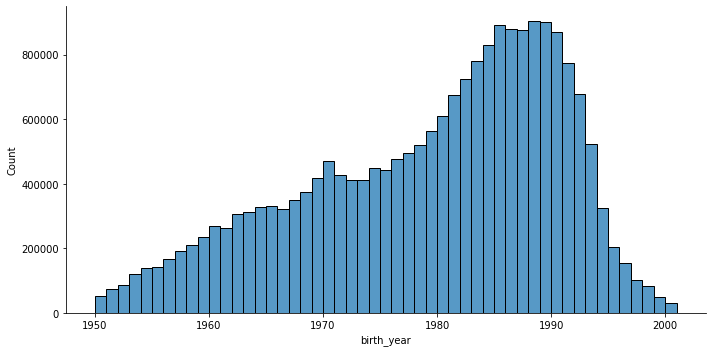

In [23]:
#plot disribution of age based on riders
sns.displot(data=df, x="birth_year", bins=range(1950, 2002), aspect=8/4)

###what we see is that the heavy riders are Gen Z and Millenials (1980 - 1996)

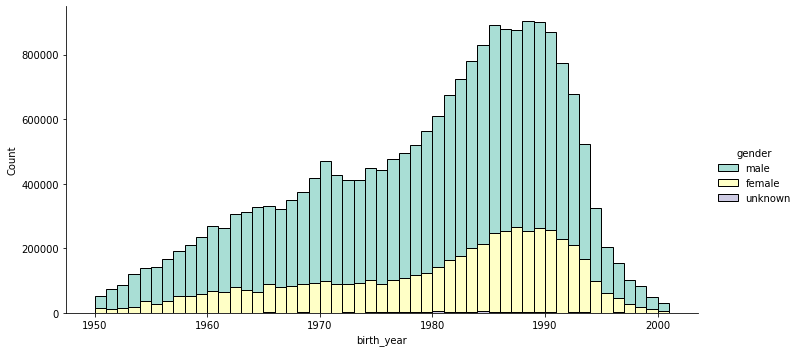

In [29]:
#plot disribution of age based on riders based on gender
sns.displot(data=df, x="birth_year", hue = "gender", multiple='stack', bins=range(1950, 2002), aspect=8/4, palette="Set3")

###female riders that also ride the citi bike heavily are alse born between 1980-1996

### Stations

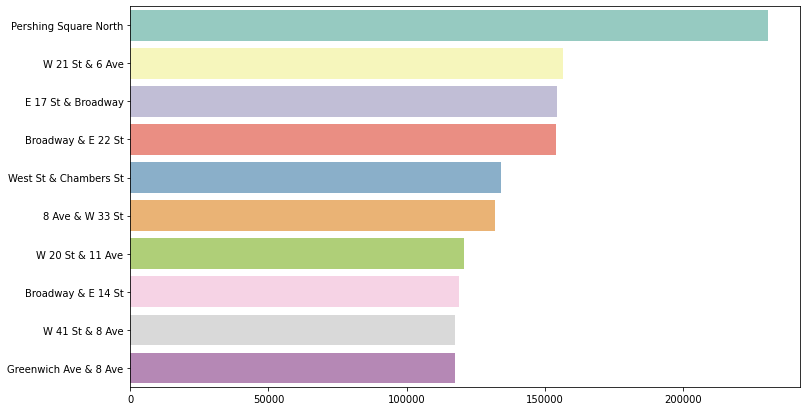

In [56]:
#we'll look at the top 10 most popular bike stations to pick up from
sstation = df['start_station_name'].value_counts()[:10]
plt.figure(figsize=(12,7))
sns.barplot( x=sstation.values , y=list(sstation.index), orient="h", palette="Set3")

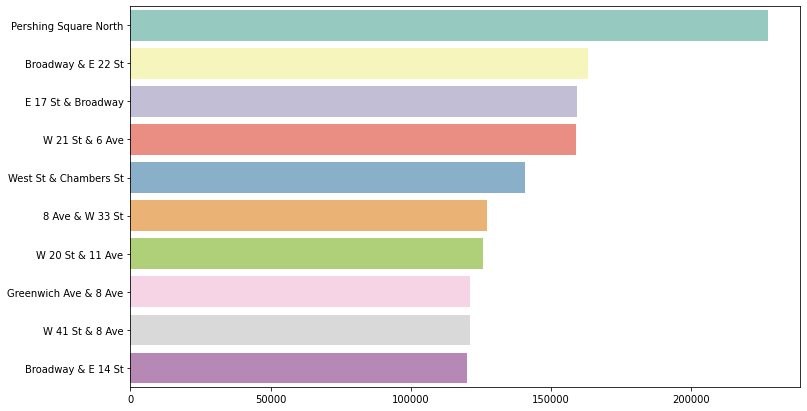

In [57]:
#we'll look at the top 10 most popular bike stations to drop off from
estation = df['end_station_name'].value_counts()[:10]
plt.figure(figsize=(12,7))
sns.barplot( x=estation.values , y=list(estation.index), orient="h", palette="Set3")

#intersting how pershing square north is the busiest station pick up and drop off stop

<a id='conclusions'></a>
## Conclusions:

> Assumptions: 
    > In the spring and summer months there are higher users due to tourism
    > There is an app to use a bike or to sign into an account to use one

> The average trip by a citibike user is about 12.4 minutes, and riders are nearly all subscribers and men

> Highest density of riders during early morning between 6 and 9, and the afternoon and late evening from 3 to 7

> On the weekend there are far less citi bike riders than on the weekday

> May to September definitely get more people riding due to the weather, longer days, and overall use.

> We observed that the heavy riders are Gen Z and Millenials (1980 - 1996) and in terms of Gender there is about 2:1 Men vs Women

> The top 10 busiest start stations are nearly the same end stations

## Recommendations:

> 1. Alta Bicycle Share should focus on running weekend camapigns where they can set up a 2-Day pass for the weekends during the high volume months to increase citi bike useage. This would help tourists get around but also allow locals to explore the city through a new method

> 2. Alta Bicycle Share should run a marketing campaign for women to engage and empower them to safetly get to and from home to work or to their leisurely activities

> 3. Since a majority of citi bike riders are Subscribe, Alta Bicycle Share should consider increasing the price of their annual subscription.

> 4. Alta Bicycle Share should consider testing out if placing more bikes in the top 10 busiest Start and End stations will increase people in buying an annual membership or being a customer. 

> Extra: Although my code wwas crashing my kernal everytime. I manually googled some of these station locations, and Alta Bicycle Share should consider looking at merging the boroughs together.